In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
data = {
    'Current': [4.646, 3.979, 3.602, 3.264, 3.143, 3.093, 3.107, 2.895],
    '07 Apr 2023': [4.624, 3.953, 3.566, 3.209, 3.093, 3.049, 3.073, 2.872],
    '10 Mar 2023': [5.043, 4.500, 4.090, 3.651, 3.460, 3.335, 3.264, 2.923],
    '11 Apr 2022': [1.842, 2.441, 2.561, 2.538, 2.524, 2.530, 2.530, 2.338]
}
maturities = [1, 2, 3, 5, 7, 10, 15, 30]
columns = ['Current', '07 Apr 2023', '10 Mar 2023', '11 Apr 2022']

swap_rates = pd.DataFrame(data, index=maturities, columns=columns)
swap_rates = swap_rates / 100 # Converting percentages to decimals

In [ ]:
def bootstrap_curve(swap_rates, maturities):
    n = len(maturities)
    discount_factors = np.zeros(n)
    forward_rates = np.zeros(n)

    S1 = swap_rates.iloc[0]
    T1 = maturities[0]
    discount_factors[0] = 1 / (1 + S1 * T1)
    forward_rates[0] = S1

    for i in range(1, n):
        Ti = maturities[i]
        Si = swap_rates.iloc[i]

        sum_prev = 0
        for j in range(i):
            sum_prev += discount_factors[j]
        discount_factors[i] = (1 - Si * sum_prev) / (1 + Si)

        delta_T = maturities[i] - maturities[i - 1]
        forward_rates[i] = (discount_factors[i-1] / discount_factors[i] - 1) / delta_T

    return discount_factors, forward_rates


In [ ]:
# Bootstrap curves for all dates
results = {}
for date in columns:
    discount_factors, forward_rates = bootstrap_curve(swap_rates[date], maturities)
    results[date] = {
        'Discount Factors': discount_factors,
        'Forward Rates': forward_rates
    }

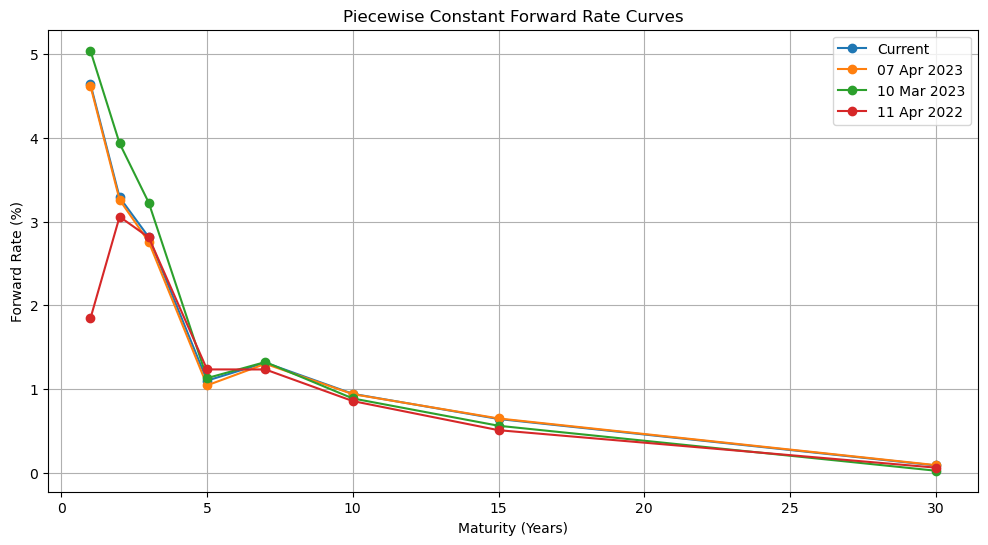


Current Forward Rates:
 Maturity  Swap Rate  Forward Rate  Discount Factor
        1      4.646      4.646000         0.955603
        2      3.979      3.290055         0.925164
        3      3.602      2.814030         0.899842
        5      3.264      1.098301         0.880501
        7      3.143      1.313334         0.857965
       10      3.093      0.940736         0.834416
       15      3.107      0.639939         0.808545
       30      2.895      0.083932         0.798493

07 Apr 2023 Forward Rates:
 Maturity  Swap Rate  Forward Rate  Discount Factor
        1      4.624      4.624000         0.955804
        2      3.953      3.260125         0.925627
        3      3.566      2.757691         0.900786
        5      3.209      1.041689         0.882402
        7      3.093      1.299366         0.860052
       10      3.049      0.937004         0.836537
       15      3.073      0.646356         0.810348
       30      2.872      0.088065         0.799783

10 Mar 2023

In [ ]:
plt.figure(figsize=(12, 6))
for date in columns:
    plt.plot(maturities, results[date]['Forward Rates'] * 100, 'o-', label=date)

plt.title('Piecewise Constant Forward Rate Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

for date in columns:
    print(f"\n{date} Forward Rates:")
    print(pd.DataFrame({
        'Maturity': maturities,
        'Swap Rate': swap_rates[date] * 100,
        'Forward Rate': results[date]['Forward Rates'] * 100,
        'Discount Factor': results[date]['Discount Factors']
    }).to_string(index=False))

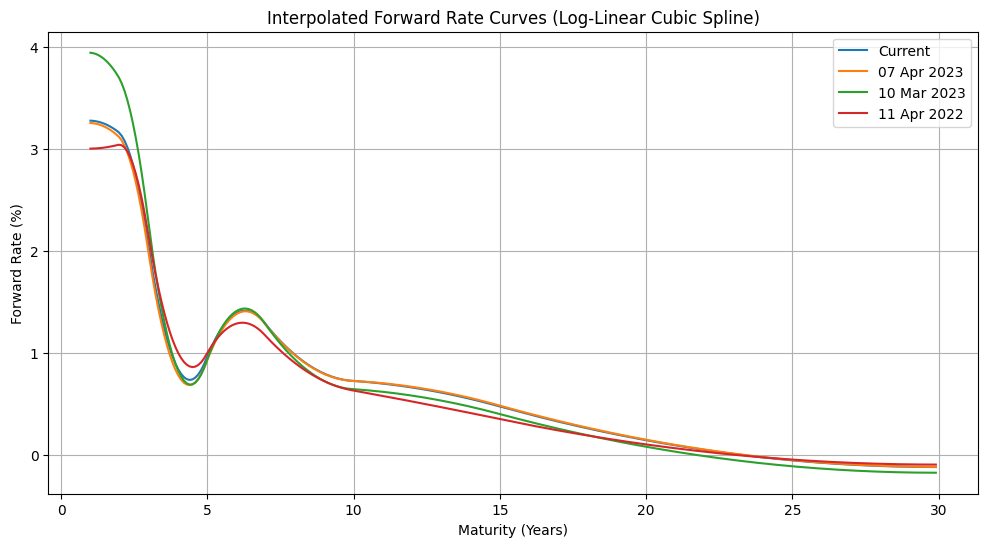

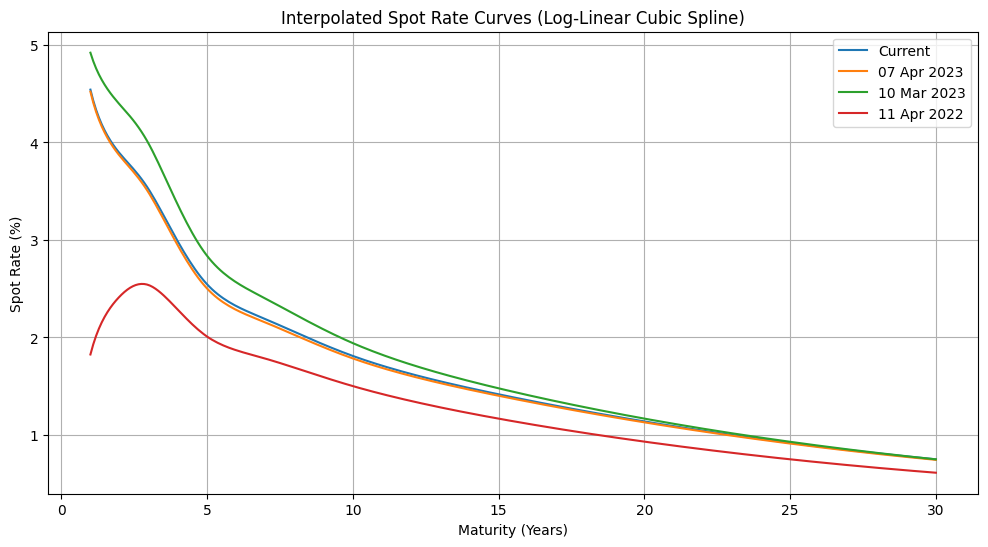


=== Repricing Accuracy Verification ===

Current Repricing Results:
 Maturity  Original  Calculated    Error (bp)
        1     4.646    4.646000  6.245005e-13
        2     3.979    3.979005 -5.293021e-04
        3     3.602    3.601991  8.616744e-04
        5     3.264    2.627139  6.368609e+01
        7     3.143    2.262945  8.800553e+01
       10     3.093    1.881634  1.211366e+02
       15     3.107    1.485287  1.621713e+02
       30     2.895    0.810942  2.084058e+02
Maximum Repricing Error: 208.4058 bp

07 Apr 2023 Repricing Results:
 Maturity  Original  Calculated    Error (bp)
        1     4.624    4.624000 -4.163336e-13
        2     3.953    3.953005 -5.039945e-04
        3     3.566    3.565991  8.587958e-04
        5     3.209    2.582511  6.264894e+01
        7     3.093    2.226458  8.665420e+01
       10     3.049    1.854277  1.194723e+02
       15     3.073    1.468425  1.604575e+02
       30     2.872    0.804226  2.067774e+02
Maximum Repricing Error: 206.7774 

In [ ]:

from scipy.interpolate import CubicSpline



maturities = [1, 2, 3, 5, 7, 10, 15, 30]
columns = ['Current', '07 Apr 2023', '10 Mar 2023', '11 Apr 2022']

swap_rates = pd.DataFrame(data, index=maturities, columns=columns)
swap_rates = swap_rates / 100

# Using original bootstrap function from part (a)
def bootstrap_curve(swap_rates, maturities):
    n = len(maturities)
    discount_factors = np.zeros(n)
    forward_rates = np.zeros(n)

    S1 = swap_rates.iloc[0]
    discount_factors[0] = 1 / (1 + S1)
    forward_rates[0] = S1

    for i in range(1, n):
        T_prev = maturities[i-1]
        T_current = maturities[i]
        S = swap_rates.iloc[i]
        sum_prev_df = sum(discount_factors[:i])
        numerator = 1 - S * sum_prev_df
        denominator = 1 + S
        discount_factors[i] = numerator / denominator
        forward_rates[i] = (discount_factors[i-1]/discount_factors[i] - 1)/(T_current - T_prev)

    return discount_factors, forward_rates

# Improved interpolation using log-linear method
def interpolate_curve_log_linear(maturities, discount_factors):
    """Interpolate using log-linear method for better stability"""
    # Interpolate log of discount factors
    log_dfs = np.log(discount_factors)
    log_df_interp = CubicSpline(maturities, log_dfs, bc_type='natural')

    # Create dense grid
    dense_mats = np.linspace(1, 30, 300)
    interp_log_dfs = log_df_interp(dense_mats)
    interp_dfs = np.exp(interp_log_dfs)

    # Calculate forward rates
    forward_rates = []
    for i in range(1, len(dense_mats)):
        T1 = dense_mats[i-1]
        T2 = dense_mats[i]
        df1 = interp_dfs[i-1]
        df2 = interp_dfs[i]
        forward_rate = (df1/df2 - 1)/(T2 - T1)
        forward_rates.append(forward_rate)

    return dense_mats, interp_dfs, np.array(forward_rates)

# Bootstrap curves and apply improved interpolation
interpolated_results = {}
for date in columns:
    # Bootstrap using original function
    discount_factors, _ = bootstrap_curve(swap_rates[date], maturities)

    # Apply log-linear interpolation
    dense_mats, interp_dfs, forward_rates = interpolate_curve_log_linear(
        maturities, discount_factors)

    interpolated_results[date] = {
        'maturities': dense_mats,
        'discount_factors': interp_dfs,
        'forward_rates': forward_rates
    }

# Plotting
plt.figure(figsize=(12, 6))
for date in columns:
    plt.plot(interpolated_results[date]['maturities'][:-1],
             interpolated_results[date]['forward_rates']*100,
             label=date)

plt.title('Interpolated Forward Rate Curves (Log-Linear Cubic Spline)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Add spot rate calculation to existing code
plt.figure(figsize=(12, 6))
for date in columns:
    dense_mats = interpolated_results[date]['maturities']
    interp_dfs = interpolated_results[date]['discount_factors']
    spot_rates = -np.log(interp_dfs) / dense_mats
    plt.plot(dense_mats, spot_rates * 100, label=date)

plt.title('Interpolated Spot Rate Curves (Log-Linear Cubic Spline)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

# Enhanced verification for all maturities
def full_repricing_verification(date):
    """Verify repricing for all maturities"""
    results = []
    discount_factors, _ = bootstrap_curve(swap_rates[date], maturities)

    for maturity in maturities:
        # Get bootstrap discount factors
        idx = maturities.index(maturity)
        original_rate = swap_rates[date].iloc[idx]

        # Get interpolated discount factors
        dense_mats, interp_dfs, _ = interpolate_curve_log_linear(maturities, discount_factors)
        log_df_interp = CubicSpline(dense_mats, np.log(interp_dfs))

        # Calculate annual DFs
        annual_mats = np.arange(1, maturity+1)
        annual_dfs = np.exp(log_df_interp(annual_mats))

        # Calculate swap rate
        sum_dfs = annual_dfs[:-1].sum()
        terminal_df = annual_dfs[-1]
        calculated_rate = (1 - terminal_df) / (sum_dfs + terminal_df)

        # Calculate error
        error_bp = (original_rate - calculated_rate) * 10000
        results.append({
            'Maturity': maturity,
            'Original': original_rate*100,
            'Calculated': calculated_rate*100,
            'Error (bp)': error_bp
        })

    return pd.DataFrame(results)

# Print verification results
print("\n=== Repricing Accuracy Verification ===")
for date in columns:
    df_verification = full_repricing_verification(date)
    print(f"\n{date} Repricing Results:")
    print(df_verification.to_string(index=False))
    max_error = df_verification['Error (bp)'].abs().max()
    print(f"Maximum Repricing Error: {max_error:.4f} bp")







--- Nelson-Siegel Best-Fit Parameters ---

Current:
  beta0 (level): 0.0266
  beta1 (slope): 0.0237
  beta2 (curve): -0.0081
  tau (decay)  : 2.0000

07 Apr 2023:
  beta0 (level): 0.0263
  beta1 (slope): 0.0238
  beta2 (curve): -0.0083
  tau (decay)  : 2.0000

10 Mar 2023:
  beta0 (level): 0.0271
  beta1 (slope): 0.0289
  beta2 (curve): -0.0056
  tau (decay)  : 2.0000

11 Apr 2022:
  beta0 (level): 0.0220
  beta1 (slope): -0.0102
  beta2 (curve): 0.0275
  tau (decay)  : 1.9999


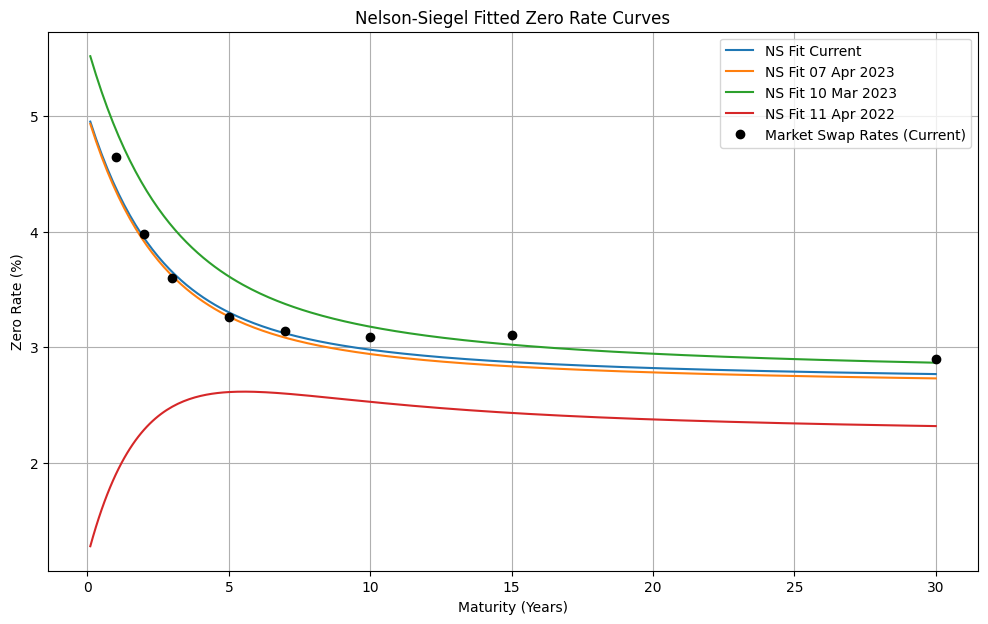

In [1]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---data (same as before) ---
data = {
    'Current': [4.646, 3.979, 3.602, 3.264, 3.143, 3.093, 3.107, 2.895],
    '07 Apr 2023': [4.624, 3.953, 3.566, 3.209, 3.093, 3.049, 3.073, 2.872],
    '10 Mar 2023': [5.043, 4.500, 4.090, 3.651, 3.460, 3.335, 3.264, 2.923],
    '11 Apr 2022': [1.842, 2.441, 2.561, 2.538, 2.524, 2.530, 2.530, 2.338]
}
maturities = [1, 2, 3, 5, 7, 10, 15, 30]
columns = ['Current', '07 Apr 2023', '10 Mar 2023', '11 Apr 2022']

swap_rates_df = pd.DataFrame(data, index=maturities)
swap_rates_df = swap_rates_df / 100
swap_rates_df['Years'] = maturities


# 1. Define the Nelson-Siegel formula (vectorized to handle arrays)
def nelson_siegel(t, beta0, beta1, beta2, tau):
    """Calculates the zero rate for given tenors using the Nelson-Siegel formula."""
    t = np.array(t, dtype=float)
    # Handle the case where t=0 to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = beta1 * (1 - np.exp(-t / tau)) / (t / tau)
        term2 = beta2 * (((1 - np.exp(-t / tau)) / (t / tau)) - np.exp(-t / tau))

    # Where t is 0, the limit is beta0 + beta1
    result = beta0 + term1 + term2
    result[t == 0] = beta0 + beta1
    return result

# 2. Create a function to price swaps using the NS model
def price_swap_with_ns(params, market_data_slice):
    """Given NS parameters, calculates the model-implied swap rates."""
    beta0, beta1, beta2, tau = params
    model_rates = []

    for tenor in market_data_slice.index:
        # We need to discount all annual cashflows
        cashflow_tenors = np.arange(1, tenor + 1)

        # Get zero rates from the NS model for each cashflow
        ns_zero_rates = nelson_siegel(cashflow_tenors, beta0, beta1, beta2, tau)

        # Convert zero rates to discount factors
        dfs = np.exp(-ns_zero_rates * cashflow_tenors)

        # Calculate the model-implied swap rate (PV Fixed = PV Float)
        pv_float_leg = 1.0 - dfs[-1]
        pv_fixed_annuity = np.sum(dfs)

        model_rate = pv_float_leg / pv_fixed_annuity
        model_rates.append(model_rate)

    return np.array(model_rates)

# 3. Define the objective function for the optimizer
def ns_objective_function(params, market_data_slice):
    """Calculates the sum of squared errors between market and model rates."""
    market_rates = market_data_slice.values
    model_rates = price_swap_with_ns(params, market_data_slice)

    # We want to minimize the squared difference
    error = np.sum((model_rates - market_rates)**2)
    return error

# 4. Run the optimization for each date
results_ns = {}
for date in columns:
    market_data_on_date = swap_rates_df[date]

    # A reasonable initial guess for the optimizer
    initial_params = [0.03, -0.01, -0.01, 2.0]

    # Run the optimization
    result = minimize(
        ns_objective_function,
        initial_params,
        args=(market_data_on_date,),
        method='SLSQP' # A robust method for constrained optimization
    )

    best_params = result.x
    results_ns[date] = best_params



print("--- Nelson-Siegel Best-Fit Parameters ---")
for date, params in results_ns.items():
    print(f"\n{date}:")
    print(f"  beta0 (level): {params[0]:.4f}")
    print(f"  beta1 (slope): {params[1]:.4f}")
    print(f"  beta2 (curve): {params[2]:.4f}")
    print(f"  tau (decay)  : {params[3]:.4f}")

# Plot the fitted curves
plt.figure(figsize=(12, 7))
fine_tenors = np.linspace(0.1, 30, 300)

for date, params in results_ns.items():
    ns_curve = nelson_siegel(fine_tenors, *params)
    plt.plot(fine_tenors, ns_curve * 100, label=f'NS Fit {date}')

# For context, plot the original market rates for one date
plt.plot(maturities, swap_rates_df['Current'] * 100, 'ko', label='Market Swap Rates (Current)')

plt.title('Nelson-Siegel Fitted Zero Rate Curves')
plt.xlabel('Maturity (Years)')
plt.ylabel('Zero Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

